<a href="https://colab.research.google.com/github/DifferentiableUniverseInitiative/JaxPM/blob/main/notebooks/Introduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install --quiet git+https://github.com/DifferentiableUniverseInitiative/JaxPM.git

In [1]:
%pylab inline

import jax
import jax.numpy as jnp
import jax_cosmo as jc

from jax.experimental.ode import odeint

from jaxpm.painting import cic_paint
from jaxpm.pm import linear_field, lpt, make_ode_fn

Populating the interactive namespace from numpy and matplotlib


In [7]:
mesh_shape= [256, 256, 256]
box_size  = [256.,256.,256.]
snapshots = jnp.linspace(0.1,1.,2)

@jax.jit
def run_simulation(omega_c, sigma8):
    # Create a small function to generate the matter power spectrum
    k = jnp.logspace(-4, 1, 128)
    pk = jc.power.linear_matter_power(jc.Planck15(Omega_c=omega_c, sigma8=sigma8), k)
    pk_fn = lambda x: jc.scipy.interpolate.interp(x.reshape([-1]), k, pk).reshape(x.shape)

    # Create initial conditions
    initial_conditions = linear_field(mesh_shape, box_size, pk_fn, seed=jax.random.PRNGKey(0))

    # Create particles
    particles = jnp.stack(jnp.meshgrid(*[jnp.arange(s) for s in mesh_shape]),axis=-1).reshape([-1,3])

    cosmo = jc.Planck15(Omega_c=omega_c, sigma8=sigma8)
    
    # Initial displacement
    dx, p, f = lpt(cosmo, initial_conditions, particles, 0.1)
    
    # Evolve the simulation forward
    res = odeint(make_ode_fn(mesh_shape), [particles+dx, p], snapshots, cosmo, rtol=1e-5, atol=1e-5)
    
    # Return the simulation volume at requested 
    return res[0]

In [10]:
res = run_simulation(0.25, 0.8)
%timeit res = run_simulation(0.25, 0.8)

1 loop, best of 5: 29.2 s per loop


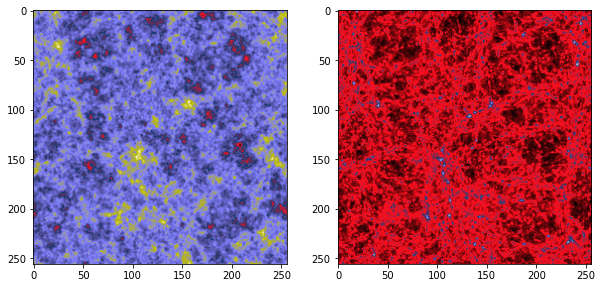

In [11]:
figure(figsize=[10,5])
subplot(121)
imshow(cic_paint(jnp.zeros(mesh_shape), res[0]).sum(axis=0),cmap='gist_stern')
subplot(122)
imshow(cic_paint(jnp.zeros(mesh_shape), res[1]).sum(axis=0),cmap='gist_stern')